In [1]:
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')

In [2]:
import os
import tensorflow as tf
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'    # ignore information messages

from tensorflow.keras.datasets import cifar10

from tensorflow.keras import Sequential, Input, Model, callbacks
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import (BinaryAccuracy, Precision, Recall, AUC, 
                                      FalsePositives, FalseNegatives, TruePositives, TrueNegatives)

import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [3]:
# folder_var = 'data1/train/malignant/'
# folder_yok = 'data1/train/benign/'
# folder_test_var = 'data1/test/malignant/'
# folder_test_yok = 'data1/test/benign/'

folder_train = 'data1/train/'
folder_validation = 'data1/validation/'
folder_test = 'data1/test/'

In [4]:
directory_list = list()
for root, dirs, files in os.walk('data1/', topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(root, name))

# print (directory_list)

def load_images_from_folder(folder):
    for root, dirs, files in os.walk(folder):
        for file in files:
            i = 0
            if file.endswith('.DS_Store'):
                path = os.path.join(root, file)
                print ("Deleting: %s" % (path))
                if os.remove(path):
                    print ("Unable to delete!")
                else:
                    print ("Deleted...")
                    i += 1
                print("Files Deleted: %d" % (i))

for folder in directory_list:
    load_images_from_folder(folder)

In [5]:
def num_of_files(folder):
    num_of_files = 0
    for root, dirs, files in os.walk(folder, topdown=False):
        num_of_files += len(files)
    return num_of_files
        
num_of_files_train = num_of_files(folder_train)
num_of_files_validation = num_of_files(folder_validation)
num_of_files_test = num_of_files(folder_test)
print(num_of_files_train, num_of_files_validation, num_of_files_test)

1300 245 350


In [12]:
img_height = img_width = 28
batch_size = 20

##################
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    folder_train,
    labels="inferred",
    label_mode="int",  # categorical, binary, int
    # class_names=['0', '1', '2', '3', ...]
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
#     validation_split=0.1,
#     subset="training",
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    folder_validation,
    labels="inferred",
    label_mode="int",  # categorical, binary, int
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
#     validation_split=0.1,
#     subset="validation",
)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    folder_test,
    labels="inferred",
    label_mode="int",  # categorical, binary, int
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
)

Found 1300 files belonging to 2 classes.
Found 245 files belonging to 2 classes.
Found 350 files belonging to 2 classes.


In [13]:
def augment(x, y):
    image = tf.image.random_brightness(x, max_delta=0.05)
    return image, y

In [14]:
ds_train = ds_train.map(augment)

In [15]:
# # Custom Loops
# for epochs in range(10):
#     for x, y in ds_train:
#         # train here
#         pass

In [16]:
inputs = Input(shape=(img_height, img_width, 3))
x = Conv2D(32, 3)(inputs)
x = BatchNormalization()(x)    # ?
x = relu(x)
x = MaxPooling2D()(x)
x = Conv2D(64, 3)(x)
x = BatchNormalization()(x)
x = relu(x)
x = MaxPooling2D()(x)
x = Conv2D(128, 3)(x)
x = BatchNormalization()(x)
x = relu(x)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [17]:
METRICS = [
  TruePositives(name='tp'),
  TrueNegatives(name='tn'),
  FalsePositives(name='fp'),
  FalseNegatives(name='fn'), 
  Precision(name='precision'),
  Recall(name='recall'),
  BinaryAccuracy(name='acc'),
  AUC(name='auc'),
]

model.compile(
    optimizer=Adam(),
    loss=[BinaryCrossentropy(from_logits=True),],
    metrics=METRICS,
)

In [18]:
history = model.fit(
    ds_train,
    epochs=30,
    steps_per_epoch=num_of_files_train // batch_size,
    validation_data=ds_validation,
    validation_steps=num_of_files_validation // batch_size,
)

Epoch 1/30
65/65 [==============================] - 10s 124ms/step - loss: 0.6532 - tp: 5.8182 - tn: 500.0606 - fp: 19.0758 - fn: 144.7424 - precision: 0.1983 - recall: 0.0323 - acc: 0.7404 - auc: 0.5340 - val_loss: 0.4653 - val_tp: 3.0000 - val_tn: 190.0000 - val_fp: 6.0000 - val_fn: 41.0000 - val_precision: 0.3333 - val_recall: 0.0682 - val_acc: 0.8042 - val_auc: 0.6397
Epoch 2/30
65/65 [==============================] - 8s 115ms/step - loss: 0.4853 - tp: 7.7273 - tn: 515.1061 - fp: 1.9394 - fn: 144.9242 - precision: 0.8420 - recall: 0.0645 - acc: 0.7889 - auc: 0.6907 - val_loss: 0.4851 - val_tp: 5.0000 - val_tn: 191.0000 - val_fp: 6.0000 - val_fn: 38.0000 - val_precision: 0.4545 - val_recall: 0.1163 - val_acc: 0.8167 - val_auc: 0.6741
Epoch 3/30
65/65 [==============================] - 8s 114ms/step - loss: 0.4750 - tp: 18.0909 - tn: 508.8182 - fp: 7.7273 - fn: 135.0606 - precision: 0.6912 - recall: 0.1334 - acc: 0.7882 - auc: 0.7281 - val_loss: 0.5643 - val_tp: 18.0000 - val_tn: 15

Epoch 23/30
65/65 [==============================] - 8s 110ms/step - loss: 5.9895e-04 - tp: 152.4394 - tn: 517.2576 - fp: 0.0000e+00 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - acc: 1.0000 - auc: 1.0000 - val_loss: 1.0177 - val_tp: 11.0000 - val_tn: 180.0000 - val_fp: 18.0000 - val_fn: 31.0000 - val_precision: 0.3793 - val_recall: 0.2619 - val_acc: 0.7958 - val_auc: 0.6699
Epoch 24/30
65/65 [==============================] - 8s 109ms/step - loss: 4.8751e-04 - tp: 152.9394 - tn: 516.7576 - fp: 0.0000e+00 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - acc: 1.0000 - auc: 1.0000 - val_loss: 1.0130 - val_tp: 14.0000 - val_tn: 177.0000 - val_fp: 19.0000 - val_fn: 30.0000 - val_precision: 0.4242 - val_recall: 0.3182 - val_acc: 0.7958 - val_auc: 0.6734
Epoch 25/30
65/65 [==============================] - 8s 111ms/step - loss: 3.5607e-04 - tp: 156.0152 - tn: 513.6818 - fp: 0.0000e+00 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - acc: 1.0000 - auc: 1.0000 - val_los

In [ ]:
model.evaluate(ds_test)

In [19]:
result = model.evaluate(ds_test)
((result[1]+result[2]) / num_of_files_test) * 100

18/18 [==============================] - 2s 56ms/step - loss: 1.0790 - tp: 11.0000 - tn: 253.0000 - fp: 47.0000 - fn: 39.0000 - precision: 0.1897 - recall: 0.2200 - acc: 0.7543 - auc: 0.5975


75.42857142857143

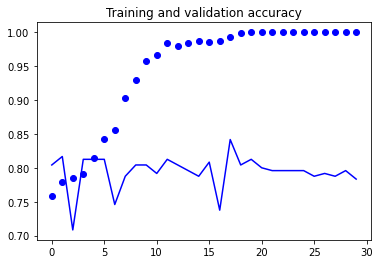

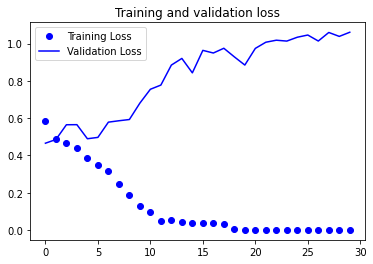

In [20]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
folder_train = 'data1/train/'
folder_validation = 'data1/validation/'
folder_test = 'data1/test/'

num_of_files_train = num_of_files(folder_train)
num_of_files_validation = num_of_files(folder_validation)
num_of_files_test = num_of_files(folder_test)

img_height = img_width = 28
batch_size = 20

##################

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    folder_train,
    labels="inferred",
    label_mode="int",  # categorical, binary, int
    # class_names=['0', '1', '2', '3', ...]
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
)

ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
    folder_validation,
    labels="inferred",
    label_mode="int",  # categorical, binary, int
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),  # reshape if not in this size
    shuffle=True,
    seed=123,
)

ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    folder_test,
    labels="inferred",
    label_mode="int",  # categorical, binary, int
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
)

def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)
    image = tf.image.random_flip_left_right(image)  # 50%
    image = tf.image.random_flip_up_down(image) #%50%

    return image, label

ds_train = ds_train.map(augment)

##################

model = Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

##################

METRICS = [
  TruePositives(name='tp'),
  TrueNegatives(name='tn'),
  FalsePositives(name='fp'),
  FalseNegatives(name='fn'), 
  Precision(name='precision'),
  Recall(name='recall'),
  BinaryAccuracy(name='acc'),
  AUC(name='auc'),
]

model.compile(
    optimizer=Adam(),
    loss=[BinaryCrossentropy(from_logits=True),],
    metrics=METRICS,
)

history = model.fit(
    ds_train,
    epochs=30,
    steps_per_epoch=num_of_files_train // batch_size,
    validation_data=ds_validation,
    validation_steps=num_of_files_validation // batch_size,
)

Found 1300 files belonging to 2 classes.
Found 245 files belonging to 2 classes.
Found 350 files belonging to 2 classes.
Epoch 1/30
65/65 [==============================] - 10s 125ms/step - loss: 0.6203 - tp: 8.4697 - tn: 476.5000 - fp: 42.6364 - fn: 142.0909 - precision: 0.1116 - recall: 0.0395 - acc: 0.7439 - auc: 0.5290 - val_loss: 0.7548 - val_tp: 0.0000e+00 - val_tn: 195.0000 - val_fp: 1.0000 - val_fn: 44.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.8125 - val_auc: 0.6142
Epoch 2/30
65/65 [==============================] - 8s 112ms/step - loss: 0.5718 - tp: 7.6061 - tn: 488.3939 - fp: 28.6515 - fn: 145.0455 - precision: 0.2524 - recall: 0.0575 - acc: 0.7501 - auc: 0.5461 - val_loss: 0.5800 - val_tp: 0.0000e+00 - val_tn: 197.0000 - val_fp: 0.0000e+00 - val_fn: 43.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.8208 - val_auc: 0.5224
Epoch 3/30
65/65 [==============================] - 8s 111ms/step - loss: 0.5911 - tp: 12.6818 - tn: 4

65/65 [==============================] - 8s 114ms/step - loss: 0.5282 - tp: 0.2424 - tn: 516.3485 - fp: 1.6667 - fn: 151.4394 - precision: 0.0545 - recall: 8.9798e-04 - acc: 0.7769 - auc: 0.5834 - val_loss: 0.8864 - val_tp: 0.0000e+00 - val_tn: 195.0000 - val_fp: 0.0000e+00 - val_fn: 45.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.8125 - val_auc: 0.4728
Epoch 23/30
65/65 [==============================] - 8s 110ms/step - loss: 0.5315 - tp: 0.3788 - tn: 516.8333 - fp: 0.4242 - fn: 152.0606 - precision: 0.1894 - recall: 0.0016 - acc: 0.7797 - auc: 0.5625 - val_loss: 0.7946 - val_tp: 1.0000 - val_tn: 185.0000 - val_fp: 13.0000 - val_fn: 41.0000 - val_precision: 0.0714 - val_recall: 0.0238 - val_acc: 0.7750 - val_auc: 0.4997
Epoch 24/30
65/65 [==============================] - 8s 112ms/step - loss: 0.5259 - tp: 1.4091 - tn: 515.3939 - fp: 1.3636 - fn: 151.5303 - precision: 0.3177 - recall: 0.0062 - acc: 0.7752 - auc: 0.5974 - val_loss: 0.8659 - val_tp: 0.0000e+00 

In [23]:
result = model.evaluate(ds_test)
((result[1]+result[2]) / num_of_files_test) * 100

18/18 [==============================] - 2s 58ms/step - loss: 0.5898 - tp: 0.0000e+00 - tn: 300.0000 - fp: 0.0000e+00 - fn: 50.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.8571 - auc: 0.5647


85.71428571428571

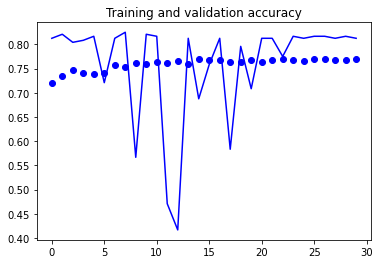

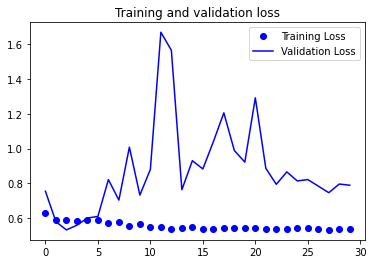

In [24]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()